### Notebook from : https://www.kaggle.com/code/jiaowoguanren/sars-cov-2-ct-scan-dataset-classification-tf-0-99

In [ ]:
%pip install split-folders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import pathlib, splitfolders
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *

from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

# USE OF SARSCOV2-CTSCAN-DATASET

In [2]:
epochs = 30
batch_size = 32
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)

def create_data_binary(data_bs):
    data_bs = pathlib.Path(data_bs)
    splitfolders.ratio(data_bs, output='../sarscov2-ctscan-dataset-splitted/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)
    data_gen = ImageDataGenerator(rescale=1.0 / 255)
    train_ds = data_gen.flow_from_directory('../sarscov2-ctscan-dataset-splitted/train/', target_size=(img_height, img_width),
                                            class_mode='binary', batch_size=batch_size, subset='training')
    val_ds = data_gen.flow_from_directory('../sarscov2-ctscan-dataset-splitted/val/', target_size=(img_height, img_width),
                                          class_mode='binary', batch_size=batch_size, shuffle=False)
    test_ds = data_gen.flow_from_directory('../sarscov2-ctscan-dataset-splitted/test/', target_size=(img_height, img_width),
                                          class_mode='binary', batch_size=batch_size, shuffle=False)
    return train_ds, val_ds, test_ds


train_data, val_data, test_data = create_data_binary('../sarscov2-ctscan-dataset/')

Copying files: 2481 files [00:01, 1471.00 files/s]

Found 1736 images belonging to 2 classes.
Found 371 images belonging to 2 classes.
Found 374 images belonging to 2 classes.


# USE OF COVID-CT-master DATASET

In [ ]:
epochs = 10
batch_size = 32
img_height, img_width = 150, 150
input_shape = (img_height, img_width, 3)

data_gen = ImageDataGenerator(rescale=1.0 / 255)

"""
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
"""
                                  
train_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/train/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          subset='training')
                                         
test_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/test/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary')

val_data = data_gen.flow_from_directory("../COVID-CT-master/Dataset/val/",
                                          target_size=(img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'binary',
                                          shuffle=False)

### Base Model CNN

In [ ]:
class BaseModel(tf.keras.Model):
    def __init__(self):
        super(BaseModel, self).__init__()

        self.C1 = Conv2D(32, (3 * 3), padding='same', input_shape = input_shape)
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.P1 = MaxPooling2D(2, padding='same')
        
        self.C2 = Conv2D(32, (3 * 3), padding='same')
        self.B2 = BatchNormalization()
        self.A2 = Activation('relu')
        self.P2 = MaxPooling2D(2, padding='same')
        self.Dr1 = Dropout(0.3)
        
        self.C3 = Conv2D(32, (3 * 3), padding='same')
        self.B3 = BatchNormalization()
        self.A3 = Activation('relu')
        self.P3 = MaxPooling2D(2, padding='same')
        self.Dr2 = Dropout(0.3)
        
        self.F1 = Flatten()
        self.D1 = Dense(256, activation='relu')
        self.B4 = BatchNormalization()
        self.D2 = Dense(256, activation='relu')
        self.D3 = Dense(256, activation='relu')
        self.D4 = Dense(256, activation='relu')
        self.Dr3 = Dropout(0.3)
        self.D5 = Dense(1, activation='sigmoid')
        
        
    def call(self, x):
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.P1(x)
        
        x = self.C2(x)
        x = self.B2(x)
        x = self.A2(x)
        x = self.P2(x)
        x = self.Dr1(x)
        
        x = self.C3(x)
        x = self.B3(x)
        x = self.A3(x)
        x = self.P3(x)
        x = self.Dr2(x)
        
        x = self.F1(x)
        x = self.D1(x)
        x = self.B4(x)
        x = self.D2(x)
        x = self.D3(x)
        x = self.D4(x)
        x = self.Dr3(x)
        y = self.D5(x)
        
        return y
    
    def __repr__(self):
        name = 'Huang_Model'
        return name
    
    
net = BaseModel()

net.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

checkpoint_save_path = './Model.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    net.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path, save_weights_only=True,
                                                 save_best_only=True)

#history = net.fit(train_data, epochs=30, batch_size=batch_size, callbacks=[cp_callback])
history = net.fit(train_data, epochs=30, batch_size=batch_size)

net.summary()

file = open('./weights.txt', 'w')
for v in net.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')

file.close()

In [7]:
net = tf.keras.Sequential(
    [
        Conv2D(32, (3 * 3), padding='same', input_shape = input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, padding='same'),

        Conv2D(32, (3 * 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, padding='same'),
        Dropout(0.3),

        Conv2D(32, (3 * 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, padding='same'),
        Dropout(0.3),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ]
)

net.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Define the callbacks
#early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#checkpoint = ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True, save_weights_only=True)

history = net.fit(train_data, epochs=20, batch_size=batch_size, validation_data=val_data)
#history = net.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[early_stop, checkpoint])

net.summary()

Epoch 1/20


2023-03-17 10:30:32.269407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.7523

2023-03-17 10:31:15.815780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 47s 834ms/step - loss: 0.5127 - accuracy: 0.7523 - val_loss: 6.4742 - val_accuracy: 0.6253
Epoch 2/20
55/55 [==============================] - 48s 874ms/step - loss: 0.3561 - accuracy: 0.8468 - val_loss: 9.0036 - val_accuracy: 0.4987
Epoch 3/20
55/55 [==============================] - 54s 993ms/step - loss: 0.2687 - accuracy: 0.8865 - val_loss: 7.4976 - val_accuracy: 0.4906
Epoch 4/20
55/55 [==============================] - 55s 1000ms/step - loss: 0.2367 - accuracy: 0.9032 - val_loss: 1.0514 - val_accuracy: 0.7412
Epoch 5/20
55/55 [==============================] - 56s 1s/step - loss: 0.1840 - accuracy: 0.9257 - val_loss: 5.5191 - val_accuracy: 0.7224
Epoch 6/20
55/55 [==============================] - 56s 1s/step - loss: 0.1642 - accuracy: 0.9338 - val_loss: 2.6854 - val_accuracy: 0.7143
Epoch 7/20
55/55 [==============================] - 56s 1s/step - loss: 0.1337 - accuracy: 0.9430 - val_loss: 7.1277 - val_accuracy: 0.6712
Epoch 8/20
55/55 [

In [8]:
test_loss, test_acc = net.evaluate(test_data)
print("Test loss: %.3f" % test_loss)
print("Test accuracy: %.3f" % test_acc)

12/12 [==============================] - 4s 302ms/step - loss: 0.3787 - accuracy: 0.9225
Test loss: 0.379
Test accuracy: 0.922


### VGG16 CNN

In [ ]:
# Load the VGG16 model with pre-trained weights
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers in the model
for layer in vgg16_model.layers:
    layer.trainable = False

# Add a new classifier on top of the pre-trained model
model = tf.keras.Sequential([
    vgg16_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Define the callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True, save_weights_only=True)

# Train the model with the training data and validate on the validation data
history = model.fit(train_data, epochs=10, validation_data=val_data)
#history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[early_stop, checkpoint])

### Accuracy and Loss graphs

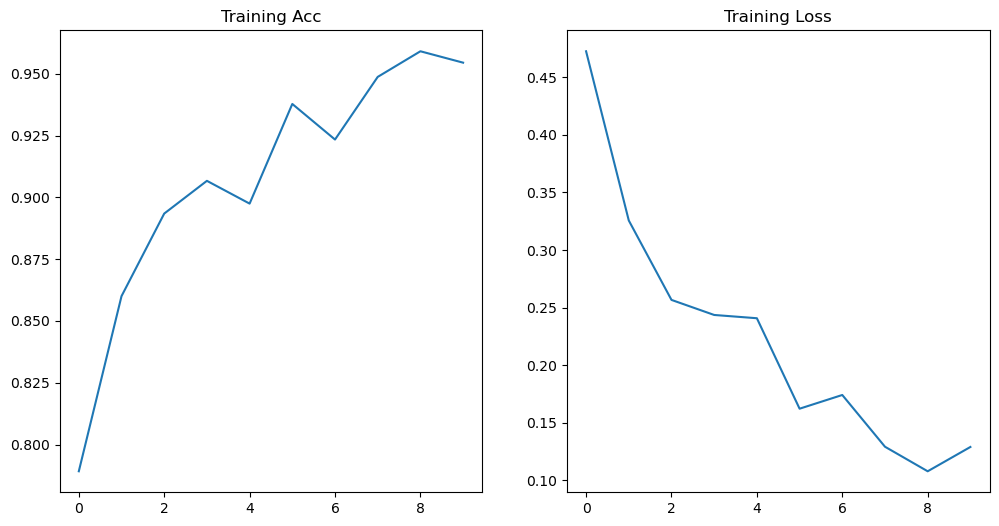

In [6]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.title('Training Acc')

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.title('Training Loss')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print("Test loss: %.3f" % test_loss)
print("Test accuracy: %.3f" % test_acc)